Tic Tac Toe
---
Two players against each other

<img style="float:left" src="board.png" alt="drawing" width="200"/>

In [1]:
import numpy as np
import pickle
from tqdm import tqdm, tqdm_notebook
import multiprocessing
import matplotlib.pyplot as plt
import collections
from time import perf_counter
import cProfile

In [2]:
BOARD_ROWS = 3
BOARD_COLS = 3
WIN = 3
assert WIN <= min(BOARD_ROWS, BOARD_COLS)

In [3]:
np.random.seed(seed=42)

### Board State
---
Reflect & Judge the state

2 players p1 and p2; p1 uses symbol 1 and p2 uses symbol 2, vacancy as 0

In [4]:
class State:
    def __init__(self, p1, p2):
        self.board = np.zeros((BOARD_ROWS, BOARD_COLS))
        self.p1 = p1
        self.p2 = p2
        self.isEnd = False
        self.boardHash = None
        # init p1 plays first
        self.playerSymbol = 1
        self.available_positions = {j+i*BOARD_COLS: (i, j) for i in range(BOARD_ROWS) for j in range(BOARD_COLS)}
        self.results = {
            'played': 0,
            'p1': [],
            'p2': [],
            'tie': []
        }
        
    
    def displayMetrics(self):
        # Sanity checks
        assert len(self.results["tie"])+len(self.results["p1"]) + len(self.results["p2"]) == self.results["played"]
        print("[INFO] {} games played".format(self.results["played"]))
        print("P1 won: {} | P2 won: {} | Ties: {}"
              .format(len(self.results["p1"]), len(self.results["p2"]), len(self.results["tie"])))
        
        expand_result = np.zeros((self.results['played'],))
        for game in self.results['p1']:
            expand_result[game[0]] = 1
        for game in self.results['p2']:
            expand_result[game[0]] = -1
        
        """
        # Linear scatter plot
        plt.figure(figsize=(15, 5))
        plt.scatter(range(self.results["played"]), expand_result, alpha=0.1)
        plt.title('Overall training result')
        plt.xlabel('Game number')
        plt.ylabel('Won by')
        
        # Do the same with a semilogx instead
        plt.figure(figsize=(15, 5))
        plt.semilogx(range(self.results["played"]), expand_result, linestyle="", marker=".", alpha=0.1)
        plt.title('Overall training result')
        plt.xlabel('Game number')
        plt.ylabel('Won by')
        """
        
        # Cum sum plot might be better?
        cum_p1 = np.zeros((self.results['played'],))
        cum_p2 = np.zeros((self.results['played'],))
        cum_tie = np.zeros((self.results['played'],))
        if expand_result[0] == 1: cum_p1[0] = 1
        if expand_result[0] == -1: cum_p2[0] = 1
        if expand_result[0] == 0: cum_tie[0] = 1
        for i in range(1, self.results['played']):
            cum_p1[i] = cum_p1[i-1] + 1 if expand_result[i] == 1 else cum_p1[i-1]
            cum_p2[i] = cum_p2[i-1] + 1 if expand_result[i] == -1 else cum_p2[i-1]
            cum_tie[i] = cum_tie[i-1] + 1 if expand_result[i] == 0 else cum_tie[i-1]
        plt.figure(figsize=(15, 5))
        plt.plot(cum_p1, label='Player 1')
        plt.plot(cum_p2, label='Player 2')
        plt.plot(cum_tie, label='Tie')
        plt.legend()
        plt.title("Cumulative win sum")
        plt.xlabel('Game number')
        plt.ylabel('Cumulative score')
        
        # Learning & exploration rate over time
        plt.figure(figsize=(15, 5))
        lr = [self.p1.learningRate(k) for k in range(self.results['played'])]
        explo = [self.p1.explorationRate(k) for k in range(self.results['played'])]
        plt.plot(lr, label='Learning rate')
        plt.plot(explo, label='Exploration rate')
        plt.title('Evolution of the learning & exploration rates')
        plt.xlabel('Game number')
        plt.ylabel('Rate')
        plt.legend()
    
    # get unique hash of current board state
    def getHash(self, method='tostring'):
        if method == 'str':
            self.boardHash = str(self.board.reshape(BOARD_COLS*BOARD_ROWS))
        elif method == 'tostring':
            self.boardHash = self.board.tostring()
        return self.boardHash
    
    def winner(self):
        """
        Checks if there is a winner already or not by hecking rows, cols and diag on the board.
        The whole board is rechecked, which wastes some time.
        return: 1 of player 1 won, -1 if player 2, 0 if tie
        """
        #print("Checking the board - still {} positions to play".format(len(self.available_positions)))
        # row
        for i in range(BOARD_ROWS):
            if sum(self.board[i, :]) == WIN:
                self.isEnd = True
                return 1
            if sum(self.board[i, :]) == -WIN:
                self.isEnd = True
                return -1
        # col
        for i in range(BOARD_COLS):
            if sum(self.board[:, i]) == WIN:
                self.isEnd = True
                return 1
            if sum(self.board[:, i]) == -WIN:
                self.isEnd = True
                return -1
        
        """Should use hills/dales"""
        # diagonal
        diag_sum1 = sum([self.board[i, i] for i in range(BOARD_COLS)])
        diag_sum2 = sum([self.board[i, BOARD_COLS-i-1] for i in range(BOARD_COLS)])
        diag_sum = max(diag_sum1, diag_sum2)
        if diag_sum == WIN:
            self.isEnd = True
            return 1
        if diag_sum == -WIN:
            self.isEnd = True
            return -1
        
        # tie
        # no available positions
        #if len(self.availablePositions()) == 0:
        if len(self.available_positions) == 0:
            self.isEnd = True
            return 0
        # not end
        self.isEnd = False
        return None
    
    """
    def availablePositions(self):
        positions = []
        for i in range(BOARD_ROWS):
            for j in range(BOARD_COLS):
                if self.board[i, j] == 0:
                    positions.append((i, j))  # need to be tuple
        return positions
    """
    
    def updateState(self, position):
        self.board[position] = self.playerSymbol
        # switch to another player
        self.playerSymbol = -1 if self.playerSymbol == 1 else 1
    
    # only when game ends
    def giveReward(self):
        result = self.winner()
        # backpropagate reward
        if result == 1:  # p1 won
            self.p1.feedReward(1, self.game_number)
            self.p2.feedReward(0, self.game_number)
        elif result == -1:  # p2 won
            self.p1.feedReward(0, self.game_number)
            self.p2.feedReward(1, self.game_number)
        else:  # There was a tie or the game is still running
            self.p1.feedReward(0.1, self.game_number)
            self.p2.feedReward(0.5, self.game_number)
        
    
    # board reset
    def reset(self):
        self.board = np.zeros((BOARD_ROWS, BOARD_COLS))
        self.boardHash = None
        self.isEnd = False
        self.playerSymbol = 1
        self.available_positions = {j+i*BOARD_COLS: (i, j) for i in range(BOARD_ROWS) for j in range(BOARD_COLS)}
    
    def play(self, rounds=100):
        for i in tqdm_notebook(range(rounds)):
            self.game_number = i
            if i%1000 == 0:
                print("Saving policy at round {}".format(i))
                self.p1.savePolicy(title='p1r'+str(i))
            #assert not self.isEnd
            turns = 0  # Tracks how many turns were played before a winner was found
            
            while not self.isEnd:
                # Player 1
                #positions = self.availablePositions()
                p1_action = self.p1.chooseAction(self.available_positions, self.board, self.playerSymbol, self.game_number)
                
                # take action and upate board state
                self.updateState(p1_action)
                board_hash = self.getHash()
                self.p1.addState(board_hash)
                
                # check board status if it is end

                win = self.winner()
                if win is not None:
                    # self.showBoard()
                    # ended with p1 either win or draw
                    if win == 1:
                        self.results['p1'].append((i, turns))
                    elif win == 0:
                        self.results['tie'].append((i, turns))
                    else:
                        raise ValueError('[ERROR] Only p1 can have won at this stage or tied')
                    self.giveReward()
                    self.p1.reset()
                    self.p2.reset()
                    self.reset()
                    break

                else:
                    # Player 2
                    #positions = self.availablePositions()
                    p2_action = self.p2.chooseAction(self.available_positions, self.board, self.playerSymbol, self.game_number)
                    self.updateState(p2_action)
                    board_hash = self.getHash()
                    self.p2.addState(board_hash)
                    
                    win = self.winner()
                    if win is not None:
                        # self.showBoard()
                        # ended with p2 either win or draw
                        if win == -1:
                            self.results['p2'].append((i, turns))
                        elif win == 0:
                            self.results['tie'].append((i, turns))
                        else:
                            raise ValueError('[ERROR] Only p2 can have won at this stage or tied')
                        
                        self.giveReward()
                        self.p1.reset()
                        self.p2.reset()
                        self.reset()
                        break
                turns += 1  # Another turn was played

            
            self.results['played'] += 1
            
            
    
    # play with human
    def play2(self):
        while not self.isEnd:
            # Player 1
            #positions = self.availablePositions()
            p1_action = self.p1.chooseAction(self.available_positions, self.board, self.playerSymbol)
            # take action and upate board state
            self.updateState(p1_action)
            self.showBoard()
            # check board status if it is end
            win = self.winner()
            if win is not None:
                if win == 1:
                    print(self.p1.name, "wins!")
                else:
                    print("tie!")
                self.reset()
                break

            else:
                # Player 2
                #positions = self.availablePositions()
                p2_action = self.p2.chooseAction(self.available_positions)

                self.updateState(p2_action)
                self.showBoard()
                win = self.winner()
                if win is not None:
                    if win == -1:
                        print(self.p2.name, "wins!")
                    else:
                        print("tie!")
                    self.reset()
                    break
    
    def benchmark(self, rounds=100):        
        for i in tqdm_notebook(range(rounds)):
            if i%1000 == 0:
                print("Saving policy at round {}".format(i))
                self.p1.savePolicy(title='p1r'+str(i))
            #assert not self.isEnd
            while not self.isEnd:
                # Player 1
                #positions = self.availablePositions()
                p1_action = self.p1.chooseAction(self.available_positions, self.board, self.playerSymbol, self.game_number)
                # take action and upate board state
                self.updateState(p1_action)
                board_hash = self.getHash()
                self.p1.addState(board_hash)
                # check board status if it is end

                win = self.winner()
                if win is not None:
                    # self.showBoard()
                    # ended with p1 either win or draw
                    self.update_results
                    self.giveReward()
                    self.p1.reset()
                    self.p2.reset()
                    self.reset()
                    break

                else:
                    # Player 2
                    #positions = self.availablePositions()
                    p2_action = self.p2.chooseAction(self.available_positions, self.board, self.playerSymbol, self.game_number)
                    self.updateState(p2_action)
                    board_hash = self.getHash()
                    self.p2.addState(board_hash)
                    
                    win = self.winner()
                    if win is not None:
                        # self.showBoard()
                        # ended with p2 either win or draw
                        self.giveReward()
                        self.p1.reset()
                        self.p2.reset()
                        self.reset()
                        break

    def showBoard(self):
        # p1: x  p2: o
        for i in range(0, BOARD_ROWS):
            print('-------------')
            out = '| '
            for j in range(0, BOARD_COLS):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('-------------')    

In [5]:
class Player:
    def __init__(self, name, exp_rate=0.3):
        self.name = name
        self.states = []  # record all positions taken
        self.lr_scheduler = {
            'start': 0.2,
            'decreasing': (500, 1500),
            'end': 0.2
        }
        #self.exp_rate = exp_rate  # Exploration rate
        self.explo_scheduler = {
            'start': 0.3,
            'decreasing': (1000, 2000),
            'end': 0
        }
        self.decay_gamma = 0.9  # Discount rate
        self.states_value = {}  # state -> value
        
        # Sanity checks - make sure the schedulers have con
    def test_learningRate(self):
        assert learningRate(self, self.lr_scheduler['decreasing'][0]) == self.lr_scheduler['start']
        assert learningRate(self, self.lr_scheduler['decreasing'][1]) == self.lr_scheduler['end']
    
    def test_explorationRate(self):
        assert explorationRate(self, self.explo_scheduler['decreasing'][0]) == self.explo_scheduler['start']
        assert explorationRate(self, self.explo_scheduler['decreasing'][1]) == self.explo_scheduler['end']
        
        
    def learningRate(self, iteration):
        if iteration < self.lr_scheduler['decreasing'][0]:
            return self.lr_scheduler['start']
        elif self.lr_scheduler['decreasing'][0] <= iteration < self.lr_scheduler['decreasing'][1]:
            offset = self.lr_scheduler['decreasing'][0]
            span = self.lr_scheduler['decreasing'][1] - self.lr_scheduler['decreasing'][0]
            return self.lr_scheduler['start']-(self.lr_scheduler['start']-self.lr_scheduler['end'])*(iteration-offset)/span
        else:
            return self.lr_scheduler['end']
    
    def explorationRate(self, iteration):
        if iteration < self.explo_scheduler['decreasing'][0]:
            return self.explo_scheduler['start']
        elif self.explo_scheduler['decreasing'][0] <= iteration < self.explo_scheduler['decreasing'][1]:
            offset = self.explo_scheduler['decreasing'][0]
            span = self.explo_scheduler['decreasing'][1] - self.explo_scheduler['decreasing'][0]
            return self.explo_scheduler['start']-(self.explo_scheduler['start']-self.explo_scheduler['end'])*(iteration-offset)/span
        else:
            return self.explo_scheduler['end']
    
    
    def getHash(self, board, method='tostring'):
        if method == 'str':
            boardHash = str(board.reshape(BOARD_COLS*BOARD_ROWS))
        elif method == 'tostring':
            boardHash = board.tostring()
        return boardHash
    
    def chooseAction(self, positions, current_board, symbol, iteration):
        #if np.random.uniform(0, 1) <= self.exp_rate:
        if np.random.uniform(0, 1) <= self.explorationRate(iteration):
            # take random action
            idx = np.random.choice(len(positions))
            action = positions[idx]
            self.deletePosition(positions, idx)
        else:  # Calculate the score for all the possible upcoming states (maximum n*m for the first move)
            value_max = -999
            #i = -1
            #print(positions)
            for idx, pos in positions.items():  # Evaluate all next moves
                next_board = current_board.copy()
                next_board[pos] = symbol  # Valid because this positions has all the valid moves

                next_boardHash = self.getHash(next_board)  # Do we need that function call?
                #next_boardHash = str(next_board.reshape(BOARD_COLS*BOARD_ROWS))
                #next_boardHash = str(next_board.reshape(-1))
                #next_boardHash = next_board.tostring()

                
                #value = self.states_value.get(next_boardHash, 0)
                #print(value, value_max)
                value = 0 if self.states_value.get(next_boardHash) is None else self.states_value.get(next_boardHash)
                # print("value", value)
                
                # Selects the action with the highest value
                if value >= value_max:
                    value_max = value
                    action = pos
                    i = idx
        # print("{} takes action {}".format(self.name, action))
            self.deletePosition(positions, i)  # Played position i
        return action
    
    def deletePosition(self, positions, idx):
        # Remove that position from the dict by copying the last entry to idx
        # As random deletes are made, the index stop meaning anything and
        # are just a convenient way to randomly sample the distribution.
        len_ = len(positions)  # O(1)
        positions[idx] = positions[len_-1]  # O(1)
        del positions[len_-1]  # O(1)
            
    # append a hash state
    def addState(self, state):
        self.states.append(state)
    
    # at the end of game, backpropagate and update states value
    def feedReward(self, reward, iteration):
        for st in reversed(self.states):
            if self.states_value.get(st) is None:
                self.states_value[st] = 0
            #self.states_value[st] += self.lr*(self.decay_gamma*reward - self.states_value[st])
            self.states_value[st] += self.learningRate(iteration)*(self.decay_gamma*reward - self.states_value[st])
            reward = self.states_value[st]
            
    def reset(self):
        self.states = []
        
    def savePolicy(self, title=None):
        title = 'policy_'+str(self.name) if title is None else title
        with open(title , 'wb') as fw:
            pickle.dump(self.states_value, fw)

    def loadPolicy(self, file):
        with open(file,'rb') as fr:
            self.states_value = pickle.load(fr)

In [6]:
class HumanPlayer:
    def __init__(self, name):
        self.name = name 
    
    def chooseAction(self, positions):
        while True:
            row = int(input("Input your action row:"))
            col = int(input("Input your action col:"))
            action = (row, col)
            if action in positions.values():
                # Find the corresponding key - gettho but ok as we play vs human
                idx = next(k for k, v in positions.items() if v == action)
                self.deletePosition(positions, idx)
                return action
    
    def deletePosition(self, positions, idx):
        # Remove that position from the dict by copying the last entry to idx
        # As random deletes are made, the index stop meaning anything and
        # are just a convenient way to randomly sample the distribution.
        len_ = len(positions)  # O(1)
        positions[idx] = positions[len_-1]  # O(1)
        del positions[len_-1]  # O(1)
        
    # append a hash state
    def addState(self, state):
        pass
    
    # at the end of game, backpropagate and update states value
    def feedReward(self, reward):
        pass
            
    def reset(self):
        pass

### Training

In [7]:
p1 = Player("p1")
p2 = Player("p2")

st = State(p1, p2)
print("Training...")
st.play(3501)
#cProfile.run('st.play(3501)')

Training...


Saving policy at round 0
Saving policy at round 1000
Saving policy at round 2000
Saving policy at round 3000



[INFO] 3501 games played
P1 won: 1212 | P2 won: 365 | Ties: 1924


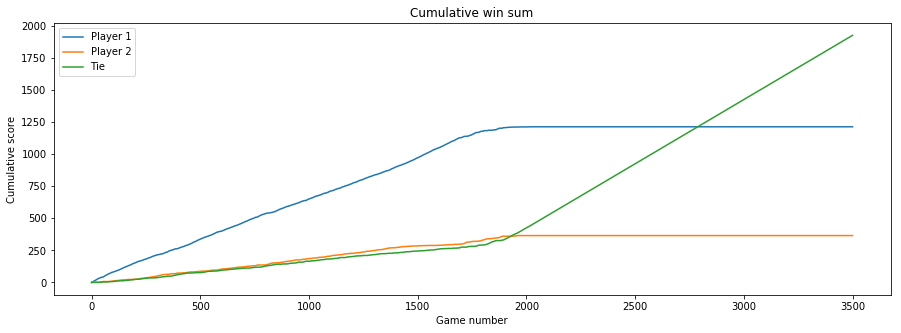

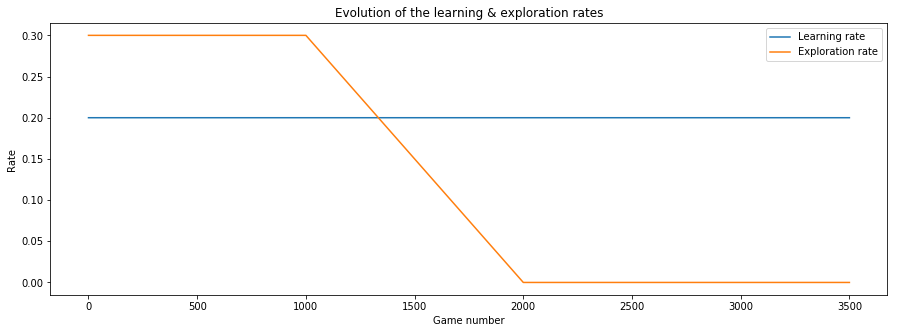

In [8]:
st.displayMetrics()

## Benchmark the policies
In this section, the policies will all play against the one with the largest iteration count in order to quantify their relative performance.

In [9]:
p1 = Player("learner", exp_rate=0)
p1.loadPolicy("p1r1000")

p2 = Player("wise", exp_rate=0)
p2.loadPolicy("p1r2000")

st = State(p1, p2)
st.play()

Saving policy at round 0



In [10]:
p1.savePolicy()
p2.savePolicy()

In [11]:
p1.loadPolicy("policy_p1")

### Human vs Computer

In [12]:
p1 = Player("computer", exp_rate=0)
p1.loadPolicy("policy_p1")

p2 = HumanPlayer("human")

st = State(p1, p2)
st.play2()

TypeError: chooseAction() missing 1 required positional argument: 'iteration'

In [ ]:
p1 = Player("computer", exp_rate=0)
p1.loadPolicy("policy_p2")

p2 = HumanPlayer("human")

st = State(p1, p2)
st.play2()

In [ ]:
n = m = 3

In [ ]:
d = {j+i*m: (i, j) for i in range(n) for j in range(m)}

In [ ]:
d